# AIT 614 PROJECT 
## DEFAULT CREDIT DATA ANALYSIS AND PREDICTION
## BY TEAM 1

## Import all necessary Libraries

In [71]:
#import findspark
#findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

In [72]:
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.sql.functions import avg

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter

In [73]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession


In [74]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pds
import numpy as np
from pyspark.sql.functions import isnan, when, count, col
import seaborn as sb 
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt

In [75]:
#spark = SparkSession.builder.master("yarn").getOrCreate()

spark = SparkSession.builder.master("local[*]").getOrCreate()

## Reading the data file

In [76]:
#Code to make it work on the clusters
#csv = spark.read.csv('/user/root/data.csv', inferSchema=True, header=True)

#code for it to work in Jupyter Lab
csv = spark.read.csv('default of credit card clients.csv', inferSchema=True, header=True)
csv.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Preprocessing: Rename PAY_0 column to PAY_1 

In [77]:
new= csv.withColumnRenamed("PAY_0","PAY_1")

In [78]:
new.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Preprocessing: Check for NULL Values and N/A Values

In [79]:
from pyspark.sql.functions import isnan, when, count, col

In [80]:
new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in new.columns]).show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  0|        0|  0|        0|       0|  0|    0|    0|    0|    0|    0|    0|        0|        0|        0|        0|        0|        0|       0|       0|       0|       0|       0|       0|                         0|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+--

**data has no NULL values in any columns**

## Preprocessing: Check for Duplicates 

Only ID column needs to be checked because each of those values should be unique

In [81]:
if new.count() > new.dropDuplicates(['ID']).count():
    raise ValueError('There are ID duplicates within the dataset')
else:
    print('There are no duplicates')

There are no duplicates


# Analysis Before SMOTE and Log Transformation 

## Drop ID Column for Analysis Before SMOTE and Log Transformation

In [82]:
new=new.drop('ID')


In [83]:
new.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|  

## Counts of each Label in dataset for Analysis Before SMOTE and Log Transformation

In [84]:
new.cube("default payment next month").count().show()

+--------------------------+-----+
|default payment next month|count|
+--------------------------+-----+
|                         1| 6636|
|                      null|30000|
|                         0|23364|
+--------------------------+-----+



## Descriptive statistics for all columns for Analysis Before SMOTE and Log Transformation

In [85]:
new.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|             PAY_1|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|         BILL_AMT4|        BILL_AMT5|       BILL_AMT6|         PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default payment next month|
+-------+------------------+------------------+------------------+

## Statistical check for Target column Before SMOTE and Log Transformation

In [86]:

new.select('default payment next month').describe().show()

+-------+--------------------------+
|summary|default payment next month|
+-------+--------------------------+
|  count|                     30000|
|   mean|                    0.2212|
| stddev|       0.41506180569093254|
|    min|                         0|
|    max|                         1|
+-------+--------------------------+



## Statistical check for BILL column Before SMOTE and Log Transformation

In [87]:

new.select('BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6').describe().show()


+-------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+
|summary|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|         BILL_AMT4|        BILL_AMT5|       BILL_AMT6|
+-------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+
|  count|            30000|            30000|            30000|             30000|            30000|           30000|
|   mean|       51223.3309|49179.07516666667|       47013.1548| 43262.94896666666|40311.40096666667|      38871.7604|
| stddev|73635.86057552966|71173.76878252832|69349.38742703677|64332.856133916444|60797.15577026471|59554.1075367459|
|    min|          -165580|           -69777|          -157264|           -170000|           -81334|         -339603|
|    max|           964511|           983931|          1664089|            891586|           927171|          961664|
+-------+-----------------+-----------------+-----------

## Statistical check for Pay_Amt Column Before SMOTE and Log Transformation

In [88]:
new.select('PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6').describe().show()


+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|         PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|
+-------+-----------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|            30000|             30000|            30000|             30000|             30000|            30000|
|   mean|        5663.5805|         5921.1635|        5225.6815| 4826.076866666666| 4799.387633333334|5215.502566666667|
| stddev|16563.28035402577|23040.870402057186|17606.96146980311|15666.159744032062|15278.305679144742|17777.46577543531|
|    min|                0|                 0|                0|                 0|                 0|                0|
|    max|           873552|           1684259|           896040|            621000|            426529|           528666|
+-------+-----------------+-----

In [89]:
new.printSchema()

root
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_1: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default payment next month: integer (nullable = true)



## Function to Potentially Convert Negative Values to Positive Before SMOTE and Log Transformation

In [90]:

from  pyspark.sql.functions import abs  

In [91]:
#new = new.withColumn('BILL_AMT1',abs(new.BILL_AMT1))
#new = new.withColumn('BILL_AMT2',abs(new.BILL_AMT2))
#new = new.withColumn('BILL_AMT3',abs(new.BILL_AMT3))
#new = new.withColumn('BILL_AMT4',abs(new.BILL_AMT4))
#new = new.withColumn('BILL_AMT5',abs(new.BILL_AMT5))
#new = new.withColumn('BILL_AMT6',abs(new.BILL_AMT6))

### conversion made no difference hence it was excluded

## Correlation Heat Map Before SMOTE and Log Transformation

In [92]:
import numpy as np
import pandas as pd

In [93]:
converted=new.select("*").toPandas()

In [94]:
import seaborn as sb 

In [95]:
res2 = converted[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
           'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
           'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
           'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 
            'PAY_AMT6','default payment next month']]

In [96]:
dat1 = res2.corr()

<Figure size 1008x1008 with 0 Axes>

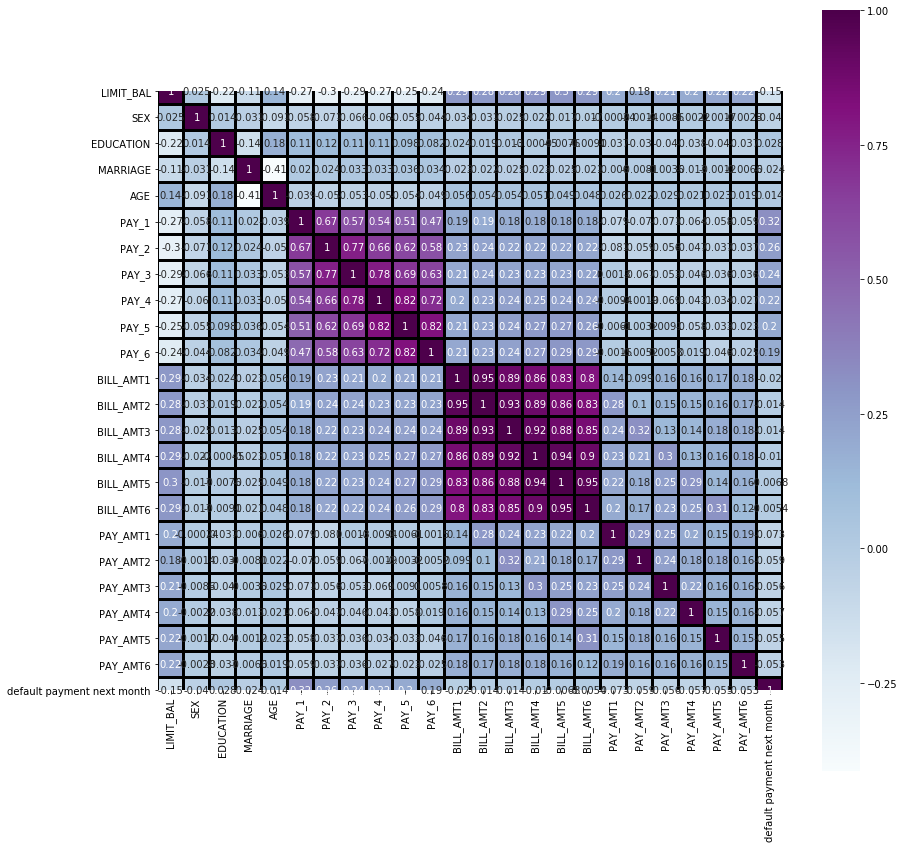

In [97]:
plt.figure(figsize = (14,14))

plt.figure(figsize = (14,14))
#plt.ylim(c, d)

a2 = sb.heatmap(dat1, annot = True, linecolor = 'Black',
                linewidths = 2, square = True, cmap="BuPu",
               fmt = '0.2g')


## Create Feature Column Before SMOTE and Log Transformation

In [98]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [99]:
#THIRD TIME - CUTOFF BEING 0.19 OR GREATER FROM HEATMAP
assembler = VectorAssembler(
    inputCols=['SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LIMIT_BAL'],
    outputCol="features")


In [100]:

output = assembler.transform(new)

In [101]:
output.printSchema()

root
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_1: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default payment next month: integer (nullable = true)
 |-- features

In [102]:
output.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|            features|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|[2.0,2.0,2.0,-1.0...|
|   120000|  2|        2|       2| 26|   -1|    2|  

## Pearson and Spearman's Correlation Before SMOTE and Log Transformation

In [103]:
from pyspark.ml.stat import Correlation

In [104]:
r2 = Correlation.corr(output, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[ 1.        , -0.05335593, -0.07214263, -0.067361  , -0.06025724,
              -0.05331697, -0.04320224,  0.05699452],
             [-0.05335593,  1.        ,  0.62717018,  0.54811191,  0.51615579,
               0.48644072,  0.46389245, -0.29646077],
             [-0.07214263,  0.62717018,  1.        ,  0.79938834,  0.71321211,
               0.67374924,  0.63520688, -0.34259615],
             [-0.067361  ,  0.54811191,  0.79938834,  1.        ,  0.80104709,
               0.71845684,  0.67142803, -0.33161501],
             [-0.06025724,  0.51615579,  0.71321211,  0.80104709,  1.        ,
               0.82217874,  0.73186645, -0.30865832],
             [-0.05331697,  0.48644072,  0.67374924,  0.71845684,  0.82217874,
               1.        ,  0.82088041, -0.28493603],
             [-0.04320224,  0.46389245,  0.63520688,  0.67142803,  0.73186645,
               0.82088041,  1.        , -0.26410456],
             [ 0.05699452, -0.29646077, 

In [105]:
r1 = Correlation.corr(output, "features","pearson").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        , -0.05764288, -0.070771  , -0.06609606, -0.06017324,
              -0.05506389, -0.04400779,  0.02475524],
             [-0.05764288,  1.        ,  0.67216438,  0.57424509,  0.53884063,
               0.50942606,  0.47455309, -0.27121433],
             [-0.070771  ,  0.67216438,  1.        ,  0.76655168,  0.66206713,
               0.62278025,  0.57550086, -0.2963821 ],
             [-0.06609606,  0.57424509,  0.76655168,  1.        ,  0.77735887,
               0.68677451,  0.63268359, -0.28612295],
             [-0.06017324,  0.53884063,  0.66206713,  0.77735887,  1.        ,
               0.81983531,  0.71644948, -0.26746001],
             [-0.05506389,  0.50942606,  0.62278025,  0.68677451,  0.81983531,
               1.        ,  0.81690016, -0.24941139],
             [-0.04400779,  0.47455309,  0.57550086,  0.63268359,  0.71644948,
               0.81690016,  1.        , -0.2351954 ],
             [ 0.02475524, -0.27121433, -

## Chi-Squared Test for Feature Selection Before SMOTE and Log Transformation

In [106]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

In [107]:
selector = ChiSqSelector(numTopFeatures=10, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="default payment next month")

In [108]:
result = selector.fit(output).transform(output)

In [109]:
result.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+--------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|            features|    selectedFeatures|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+--------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|[2.0,2.0,2.

## Create Label Column Before SMOTE and Log Transformation

In [110]:
from pyspark.ml.feature import StringIndexer

In [111]:
indexer = StringIndexer(inputCol="default payment next month", outputCol="label")

In [112]:
labelDf = indexer.fit(result).transform(result)

In [113]:

labelDf.printSchema()

root
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_1: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default payment next month: integer (nullable = true)
 |-- features

In [114]:
labelDf.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+--------------------+-----+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|            features|    selectedFeatures|label|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+--------------------+--------------------+-----+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                    

In [115]:
labelDf=labelDf.select('features','label')

In [116]:
labelDf.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0,2.0,2.0,-1.0...|  1.0|
|[2.0,-1.0,2.0,0.0...|  1.0|
|(8,[0,7],[2.0,900...|  0.0|
|(8,[0,7],[2.0,500...|  0.0|
|(8,[0,1,3,7],[1.0...|  0.0|
+--------------------+-----+
only showing top 5 rows



 ## Test-Train Split Before SMOTE and Log Transformation

In [117]:
train, test = labelDf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 20921
Test Dataset Count: 9079


## Logistic Regression Before SMOTE and Log Transformation

In [121]:
from pyspark.ml.classification import LogisticRegression

In [122]:
lr = LogisticRegression(maxIter=10, regParam=0.3, featuresCol="features",labelCol="label" ,elasticNetParam=0.8)


In [123]:
lrModel = lr.fit(train)

In [124]:
prediction = lrModel.transform(test)

In [125]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(prediction))

Test Area Under ROC 0.5


## Cross Validation for Logistic Regression model Before SMOTE and Log Transformation

In [126]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [127]:
paramGrid = ParamGridBuilder()     .addGrid(lr.regParam, [0.1,0.01])     .addGrid(lr.fitIntercept, [False, True])     .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])     .build()


In [128]:

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [129]:
cvModel= crossval.fit(train)

In [130]:
cvModel.avgMetrics

[0.699847193232181,
 0.6867408833947328,
 0.6348458023618693,
 0.7041329479436149,
 0.701917412051424,
 0.6872261177801753,
 0.7091844408416261,
 0.709447028658166,
 0.7091890379810953,
 0.7125547826457235,
 0.7136488960633475,
 0.7144029814881996]

In [131]:
predictionDf = cvModel.transform(test)

In [132]:
predictionDf.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(8,[0,1,2,7],[1.0...|  0.0|[2.50302826367199...|[0.92435384003344...|       0.0|
|(8,[0,1,2,7],[1.0...|  0.0|[2.50302826367199...|[0.92435384003344...|       0.0|
|(8,[0,1,2,7],[1.0...|  0.0|[1.78837428589972...|[0.85672784354592...|       0.0|
|(8,[0,1,2,7],[1.0...|  0.0|[1.83210311747557...|[0.86201207739300...|       0.0|
|(8,[0,1,2,7],[1.0...|  0.0|[1.83210311747557...|[0.86201207739300...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [133]:
 # Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (8,[],[])
Intercept: -1.2469953736630657


In [134]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictionDf))


Test Area Under ROC 0.7229362683116124


In [135]:
accuracy = evaluator.evaluate(predictionDf)
print(accuracy*100)

72.29362683116123


 ## Random Forest With 2 Fold Cross validation Before SMOTE and Log Transformation

In [136]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=100)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [137]:
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [138]:
cvModel_rf= crossval_rf.fit(train)

In [139]:
cvModel_rf.avgMetrics

[0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792,
 0.7617451342528792]

In [140]:
predictionDf_rf = cvModel_rf.transform(test)

In [141]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_rf, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.7604565823698504


## Random Forest with 5 Fold Cross Validation Before SMOTE and Log Transformation 


In [142]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=100)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [143]:
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5) 


In [144]:
cvModel_rf= crossval_rf.fit(train)

In [145]:
cvModel_rf.avgMetrics

[0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106,
 0.7601671763299106]

In [146]:
predictionDf_rf = cvModel_rf.transform(test)

In [147]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_rf, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.7604565823698504


## GBT Classifier with 2 fold Cross Validation Before SMOTE and Log Transformation

In [148]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

In [149]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.7675163567230863


In [150]:
crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [151]:
cvModel_gbt= crossval_gbt.fit(train)

In [152]:
cvModel_gbt.avgMetrics

[0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111,
 0.7606888302693111]

In [153]:
predictionDf_gbt = cvModel_gbt.transform(test)

In [154]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_gbt, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.7675163567230863


 ## Decision tree with 2 fold Cross Validation Before SMOTE and Log Transformation

In [155]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

In [156]:
crossval_d = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [157]:
cvModel_d= crossval_d.fit(train)

In [158]:
cvModel_d.avgMetrics

[0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783,
 0.32030924849483783]

In [159]:
predictionDf_d = cvModel_d.transform(test)

In [160]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_d, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.3180800374252064


## Support Vector Machine Before SMOTE and Log Transformation

In [161]:
from pyspark.ml.classification import LinearSVC

In [162]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [163]:
lsvcModel = lsvc.fit(train)

In [164]:
predictions_svc = lsvcModel.transform(test)

In [165]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_svc, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7154319194620093


# Analysis With SMOTE and Log Transformations

In [166]:
new= csv.withColumnRenamed("PAY_0","PAY_1")

In [167]:
new.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Drop ID Column 

In [168]:
new=new.drop('ID')


In [169]:
new.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|  

## Counts of Each Label in Dataset

In [170]:
new.cube("default payment next month").count().show()

+--------------------------+-----+
|default payment next month|count|
+--------------------------+-----+
|                         1| 6636|
|                      null|30000|
|                         0|23364|
+--------------------------+-----+



## SMOTE Technique to Balance the Unbalanced Default

In [171]:
res1 = new.select("*").toPandas()

In [172]:
res1

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [173]:
res1.columns.values

array(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default payment next month'], dtype=object)

In [174]:
res2 = res1[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
           'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
           'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
           'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 
            'PAY_AMT6']]

In [175]:
res3 = res1['default payment next month']

In [176]:
X1 = res2
Y1 = res1[['default payment next month']]

In [177]:
X1.shape, Y1.shape

((30000, 23), (30000, 1))

In [178]:
trainX1, testX1, trainY1, testY1 = train_test_split(X1, Y1, 
                                                    test_size = 0.1,
                                                   random_state = 0)

In [179]:
trainX1.columns, trainY1.columns

(Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
       dtype='object'), Index(['default payment next month'], dtype='object'))

In [180]:
smot1 = SMOTE(random_state = 14, ratio = 'auto', kind = 'regular')
re_trainX1, re_trainY1 = smot1.fit_sample(trainX1, trainY1)
print('The dataset resampled: {}'.format(Counter(re_trainY1)))
#need to figure out how to get a non warning filled output for the above line
#resampling output: (1: 21004, 0: 21004)

C:\Users\sasha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The dataset resampled: Counter({1: 21004, 0: 21004})


## Plot before Performing the SMOTE Technique

C:\Users\sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


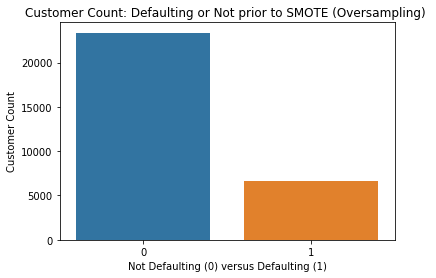

In [181]:
sb.countplot(res3).set_title("Customer Count: Defaulting or Not prior to SMOTE (Oversampling) ")
plt.xlabel("Not Defaulting (0) versus Defaulting (1)")
plt.ylabel("Customer Count")
plt.show()


## Plot after Performing the SMOTE Technique

C:\Users\sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


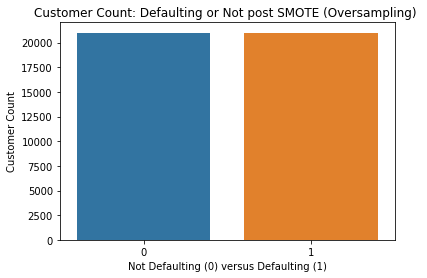

In [182]:
sb.countplot(re_trainY1).set_title("Customer Count: Defaulting or Not post SMOTE (Oversampling) ")
plt.xlabel("Not Defaulting (0) versus Defaulting (1)")
plt.ylabel("Customer Count")
plt.show()


After doing SMOTE, the dataset no longer has an uneven set of values

##  Convert the Pandas Dataframe back into the Spark Dataframe after Completing the SMOTE Technique

In [183]:
res1.columns.values

array(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default payment next month'], dtype=object)

In [184]:
dfConv1 = pds.DataFrame(re_trainX1, columns = ['LIMIT_BAL', 'SEX',
                                              'EDUCATION', 'MARRIAGE', 
                                              'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
                                              'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
                                               'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                                              'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                                              'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
                                              'PAY_AMT5', 'PAY_AMT6'])
dfConv2 = pds.DataFrame(re_trainY1, columns = ['default payment next month'])
res2 = dfConv1.combine_first(dfConv2)

In [185]:
new = spark.createDataFrame(res2)
new.show(1)


+---+---------+---------+---------+---------+---------+---------+---------+---------+--------+-----+-----+-----+-----+-----+-----+--------+--------+--------+--------+--------+--------+---+--------------------------+
|AGE|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|EDUCATION|LIMIT_BAL|MARRIAGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|SEX|default payment next month|
+---+---------+---------+---------+---------+---------+---------+---------+---------+--------+-----+-----+-----+-----+-----+-----+--------+--------+--------+--------+--------+--------+---+--------------------------+
| 27|   233637|   175918|   181089|   183180|   192223|   189681|        2|   200000|       2|    0|    0|    0|    0|    0|    2|    7000|    8100|    6600|   12000|       0|    6054|  1|                       1.0|
+---+---------+---------+---------+---------+---------+---------+---------+---------+--------+-----+-----+-----+-----+-----+-----+------

In [186]:
new.cube("default payment next month").count().show()

+--------------------------+-----+
|default payment next month|count|
+--------------------------+-----+
|                       1.0|21004|
|                      null|42008|
|                       0.0|21004|
+--------------------------+-----+



Default (1) and Not Default (0) have even counts within the set - SMOTE was successful

## Descriptive Statistics for all Columns after Performing SMOTE 

In [187]:
new.describe().show()

+-------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------------+
|summary|              AGE|         BILL_AMT1|        BILL_AMT2|        BILL_AMT3|         BILL_AMT4|        BILL_AMT5|         BILL_AMT6|         EDUCATION|         LIMIT_BAL|          MARRIAGE|              PAY_1|              PAY_2|               PAY_3|               PAY_4|               PAY_5|               PAY_6|          PAY_AMT1|          PAY_AMT2|          PAY_AMT3|          PAY_AMT4|          PAY_AMT5|          PAY_AMT6|               SEX|default payment next month|
+-------+-----------------+-------------

## Statistical Check for Target column after Performing SMOTE

In [188]:

new.select('default payment next month').describe().show()

+-------+--------------------------+
|summary|default payment next month|
+-------+--------------------------+
|  count|                     42008|
|   mean|                       0.5|
| stddev|        0.5000059513536357|
|    min|                       0.0|
|    max|                       1.0|
+-------+--------------------------+



## Statistical Check for Pay_Amt Column after Performing SMOTE

In [190]:
new.select('PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6').describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|          PAY_AMT1|          PAY_AMT2|          PAY_AMT3|          PAY_AMT4|          PAY_AMT5|          PAY_AMT6|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             42008|             42008|             42008|             42008|             42008|             42008|
|   mean| 4782.050847457627|   4919.7475004761| 4360.803799276328| 4110.886331175015| 4069.400138068939| 4417.952080556084|
| stddev|14163.523785225543|19770.990233296907|14604.896898365343|13832.427024527162|13103.797290681148|15561.535042189662|
|    min|                 0|                 0|                 0|                 0|                 0|                 0|
|    max|            873552|           1684259|            889043|            621000|            388071|            528666|
+-------

In [ ]:
new.printSchema()

## Functions to Potentially Convert Negative Values to Positive after Performing SMOTE before Log Transformation

In [192]:

from  pyspark.sql.functions import abs  

In [193]:
#new = new.withColumn('BILL_AMT1',abs(new.BILL_AMT1))
#new = new.withColumn('BILL_AMT2',abs(new.BILL_AMT2))
#new = new.withColumn('BILL_AMT3',abs(new.BILL_AMT3))
#new = new.withColumn('BILL_AMT4',abs(new.BILL_AMT4))
#new = new.withColumn('BILL_AMT5',abs(new.BILL_AMT5))
#new = new.withColumn('BILL_AMT6',abs(new.BILL_AMT6))

## Correlation Heat Map Generated After SMOTE but Prior to Log Transformation

In [194]:
import numpy as np
import pandas as pd

In [195]:
converted=new.select("*").toPandas()

In [196]:
import seaborn as sb 

In [197]:
res2 = converted[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
           'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
           'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
           'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 
            'PAY_AMT6','default payment next month']]

In [198]:
dat1 = res2.corr()

<Figure size 1008x1008 with 0 Axes>

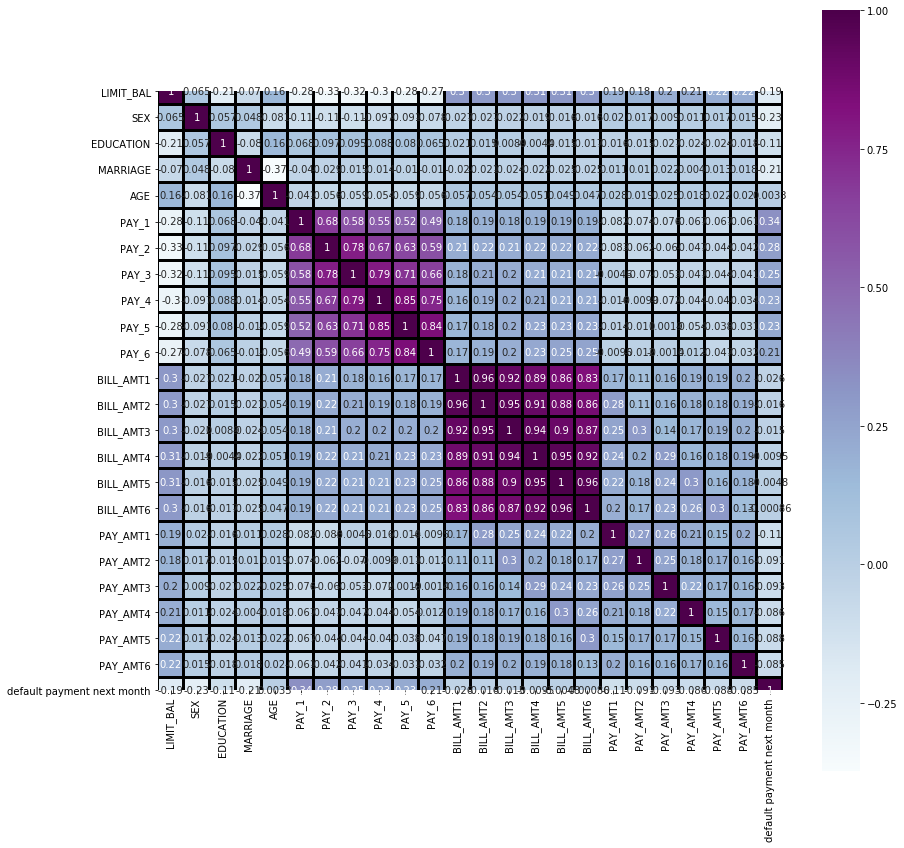

In [199]:
plt.figure(figsize = (14,14))

plt.figure(figsize = (14,14))
#plt.ylim(c, d)

a2 = sb.heatmap(dat1, annot = True, linecolor = 'Black',
                linewidths = 2, square = True, cmap="BuPu",
               fmt = '0.2g')


 ## Calculate Log values for the 6 columns After SMOTE to Conduct Log Transformation

In [200]:
res2


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,200000,1,2,2,27,0,0,0,0,0,...,183180,192223,189681,7000,8100,6600,12000,0,6054,1.0
1,160000,1,5,2,46,0,0,0,0,-2,...,0,0,0,4318,4000,0,0,0,73175,0.0
2,130000,2,1,2,27,1,-2,-1,0,0,...,29426,29100,-1410,326,32100,0,0,0,0,1.0
3,70000,1,2,2,26,0,0,0,0,0,...,60540,26890,18923,3000,4000,2000,4030,0,1000,0.0
4,330000,2,1,1,37,-2,-2,-2,-2,-2,...,0,442,0,0,10776,0,442,0,297,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42003,266971,1,1,1,44,-1,-1,-1,-1,-1,...,36416,25367,10154,2667,1946,36481,25417,10154,6722,1.0
42004,50000,2,1,2,25,2,2,2,2,2,...,35723,36337,37173,1250,1934,1365,1500,1565,1500,1.0
42005,152096,1,1,2,28,0,0,0,0,0,...,57953,56739,57944,3002,2607,2114,2110,2736,1732,1.0
42006,282529,1,1,1,40,1,2,2,2,0,...,166598,168803,167521,8620,5241,1521,5939,5836,5720,1.0


In [201]:
#Renamed so res2 may remain the same
res21 = res2

##### taking the log of the numbers for both BILL_AMT_ and for PAY_AMT_ is going to create errors. We can do two things to help combat this.
##### 1. replace 0 with a very small value (maybe 0.00001)
##### 2. after computing the log, to fill in inf values and N/A values with 0
##### will try replacing 0's with the small value 


In [202]:
#res21['BILL_AMT1'] = res21["BILL_AMT1"].replace(to_replace 0, 
#                 value = 0.00001) 
res21['BILL_AMT1'].replace({0: 0.0000001}, inplace=True)
res21['BILL_AMT2'].replace({0: 0.0000001}, inplace=True)
res21['BILL_AMT3'].replace({0: 0.0000001}, inplace=True)
res21['BILL_AMT4'].replace({0: 0.0000001}, inplace=True)
res21['BILL_AMT5'].replace({0: 0.0000001}, inplace=True)
res21['BILL_AMT6'].replace({0: 0.0000001}, inplace=True)

res21['PAY_AMT1'].replace({0: 0.0000001}, inplace=True)
res21['PAY_AMT2'].replace({0: 0.0000001}, inplace=True)
res21['PAY_AMT3'].replace({0: 0.0000001}, inplace=True)
res21['PAY_AMT4'].replace({0: 0.0000001}, inplace=True)
res21['PAY_AMT5'].replace({0: 0.0000001}, inplace=True)
res21['PAY_AMT6'].replace({0: 0.0000001}, inplace=True)


C:\Users\sasha\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [203]:
res21['BILL_AMT1_LOG'] = np.log10(res2['BILL_AMT1'])
res21['BILL_AMT2_LOG'] = np.log10(res2['BILL_AMT2'])
res21['BILL_AMT3_LOG'] = np.log10(res2['BILL_AMT3'])
res21['BILL_AMT4_LOG'] = np.log10(res2['BILL_AMT4'])
res21['BILL_AMT5_LOG'] = np.log10(res2['BILL_AMT5'])
res21['BILL_AMT6_LOG'] = np.log10(res2['BILL_AMT6'])

res21['PAY_AMT1_LOG'] = np.log10(res2['PAY_AMT1'])
res21['PAY_AMT2_LOG'] = np.log10(res2['PAY_AMT2'])
res21['PAY_AMT3_LOG'] = np.log10(res2['PAY_AMT3'])
res21['PAY_AMT4_LOG'] = np.log10(res2['PAY_AMT4'])
res21['PAY_AMT5_LOG'] = np.log10(res2['PAY_AMT5'])
res21['PAY_AMT6_LOG'] = np.log10(res2['PAY_AMT6'])

pd.options.mode.chained_assignment = None 

res21


C:\Users\sasha\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sasha\Anaconda3\lib\site-packages\ipykernel_launcher.p

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3_LOG,BILL_AMT4_LOG,BILL_AMT5_LOG,BILL_AMT6_LOG,PAY_AMT1_LOG,PAY_AMT2_LOG,PAY_AMT3_LOG,PAY_AMT4_LOG,PAY_AMT5_LOG,PAY_AMT6_LOG
0,200000,1,2,2,27,0,0,0,0,0,...,5.257892,5.262878,5.283805,5.278024,3.845098,3.908485,3.819544,4.079181,-7.000000,3.782042
1,160000,1,5,2,46,0,0,0,0,-2,...,5.212182,-7.000000,-7.000000,-7.000000,3.635283,3.602060,-7.000000,-7.000000,-7.000000,4.864363
2,130000,2,1,2,27,1,-2,-1,0,0,...,4.486515,4.468731,4.463893,NaN,2.513218,4.506505,-7.000000,-7.000000,-7.000000,-7.000000
3,70000,1,2,2,26,0,0,0,0,0,...,4.803457,4.782042,4.429591,4.276990,3.477121,3.602060,3.301030,3.605305,-7.000000,3.000000
4,330000,2,1,1,37,-2,-2,-2,-2,-2,...,4.031651,-7.000000,2.645422,-7.000000,-7.000000,4.032458,-7.000000,2.645422,-7.000000,2.472756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42003,266971,1,1,1,44,-1,-1,-1,-1,-1,...,3.287130,4.561292,4.404269,4.006637,3.426023,3.289143,4.562067,4.405124,4.006637,3.827499
42004,50000,2,1,2,25,2,2,2,2,2,...,4.546950,4.552948,4.560349,4.570228,3.096910,3.286456,3.135133,3.176091,3.194514,3.176091
42005,152096,1,1,2,28,0,0,0,0,0,...,4.841854,4.763076,4.753882,4.763008,3.477411,3.416141,3.325105,3.324282,3.437116,3.238548
42006,282529,1,1,1,40,1,2,2,2,0,...,5.227702,5.221670,5.227380,5.224069,3.935507,3.719414,3.182129,3.773713,3.766115,3.757396


##  Heatmap Generated after Log transformation and SMOTE

In [204]:
res3 = res2[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
           'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1_LOG',
           'BILL_AMT2_LOG', 'BILL_AMT3_LOG', 'BILL_AMT4_LOG', 'BILL_AMT5_LOG', 'BILL_AMT6_LOG',
           'PAY_AMT1_LOG', 'PAY_AMT2_LOG', 'PAY_AMT3_LOG', 'PAY_AMT4_LOG', 'PAY_AMT5_LOG', 
            'PAY_AMT6_LOG','default payment next month']]


In [205]:
res3

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4_LOG,BILL_AMT5_LOG,BILL_AMT6_LOG,PAY_AMT1_LOG,PAY_AMT2_LOG,PAY_AMT3_LOG,PAY_AMT4_LOG,PAY_AMT5_LOG,PAY_AMT6_LOG,default payment next month
0,200000,1,2,2,27,0,0,0,0,0,...,5.262878,5.283805,5.278024,3.845098,3.908485,3.819544,4.079181,-7.000000,3.782042,1.0
1,160000,1,5,2,46,0,0,0,0,-2,...,-7.000000,-7.000000,-7.000000,3.635283,3.602060,-7.000000,-7.000000,-7.000000,4.864363,0.0
2,130000,2,1,2,27,1,-2,-1,0,0,...,4.468731,4.463893,NaN,2.513218,4.506505,-7.000000,-7.000000,-7.000000,-7.000000,1.0
3,70000,1,2,2,26,0,0,0,0,0,...,4.782042,4.429591,4.276990,3.477121,3.602060,3.301030,3.605305,-7.000000,3.000000,0.0
4,330000,2,1,1,37,-2,-2,-2,-2,-2,...,-7.000000,2.645422,-7.000000,-7.000000,4.032458,-7.000000,2.645422,-7.000000,2.472756,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42003,266971,1,1,1,44,-1,-1,-1,-1,-1,...,4.561292,4.404269,4.006637,3.426023,3.289143,4.562067,4.405124,4.006637,3.827499,1.0
42004,50000,2,1,2,25,2,2,2,2,2,...,4.552948,4.560349,4.570228,3.096910,3.286456,3.135133,3.176091,3.194514,3.176091,1.0
42005,152096,1,1,2,28,0,0,0,0,0,...,4.763076,4.753882,4.763008,3.477411,3.416141,3.325105,3.324282,3.437116,3.238548,1.0
42006,282529,1,1,1,40,1,2,2,2,0,...,5.221670,5.227380,5.224069,3.935507,3.719414,3.182129,3.773713,3.766115,3.757396,1.0


In [206]:
dat2 = res3.corr()

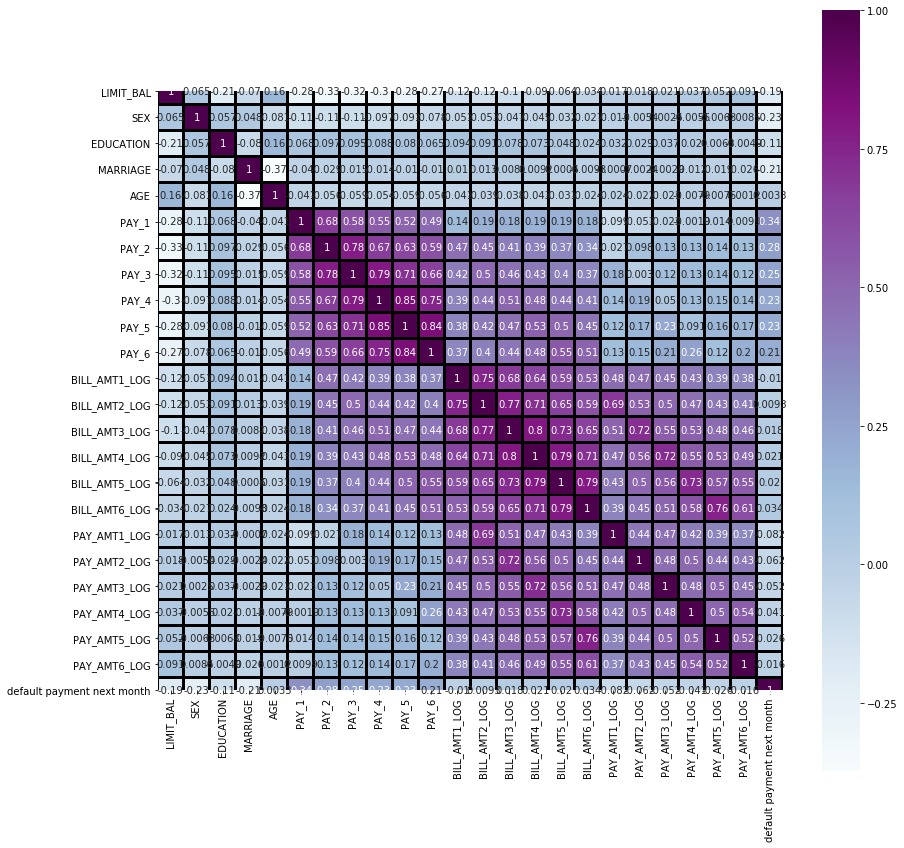

In [207]:
plt.figure(figsize = (14,14))
#plt.ylim(c, d)

a3 = sb.heatmap(dat2, annot = True, linecolor = 'Black',
                linewidths = 2, square = True, cmap="BuPu",
               fmt = '0.2g')

In [1]:
# ###### it marginally improved but not really by a lot

# Best attributes seem to be (setting at a cutoff of 0.22 or greater):
# 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'
# 
# if cutting off at 0.21 or higher: include 'MARRIAGE', 'PAY_6'

# 
# if cutting off at 0.19 or higher: include 'MARRIAGE', 'PAY_6', 'LIMIT_BAL', 'SEX'

In [209]:
new = spark.createDataFrame(res3)
new.show(1)
#does not want to work because of the false values that have appeared

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+----------------+------------------+-----------------+------------+-----------------+--------------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|     BILL_AMT1_LOG|    BILL_AMT2_LOG|    BILL_AMT3_LOG|     BILL_AMT4_LOG|    BILL_AMT5_LOG|    BILL_AMT6_LOG|     PAY_AMT1_LOG|    PAY_AMT2_LOG|      PAY_AMT3_LOG|     PAY_AMT4_LOG|PAY_AMT5_LOG|     PAY_AMT6_LOG|default payment next month|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+----------------+------------------+-----------------+------------+-----------------+--------------------------+
|   200000|  1|        2|       2| 27|    0|    0|    0

## Create a Feature Column After SMOTE and Log Transformation

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [2]:
# Reminder: Best attributes seem to be (setting at a cutoff of 0.22 or greater):
# 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'
# 
# if cutting off at 0.21 or higher: include 'MARRIAGE', 'PAY_6'


In [3]:
# Deciding best cutoff point in terms of strength while still preventing overfitting
# FIRST TIME
#assembler = VectorAssembler(
#    inputCols=["LIMIT_BAL","PAY_1", "PAY_2","PAY_3","PAY_4","PAY_5","PAY_6","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"],
#    outputCol="features")
# keeping this in here in case the model is actually worse after

In [4]:
# SECOND TIME - CUTOFF BEING 0.21 OR GREATER
#assembler = VectorAssembler(
#    inputCols=['SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'MARRIAGE'],
#    outputCol="features")

In [211]:
#THIRD TIME - CUTOFF BEING 0.22 OR GREATER FROM HEATMAP
# FOURTH TIME - CUTOFF BEING 0.19 OR GREATER FROM HEATMAP
assembler = VectorAssembler(
    inputCols=['SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'MARRIAGE', 'LIMIT_BAL'],
    outputCol="features")


In [212]:

output = assembler.transform(new)

In [213]:
output.printSchema()

root
 |-- LIMIT_BAL: long (nullable = true)
 |-- SEX: long (nullable = true)
 |-- EDUCATION: long (nullable = true)
 |-- MARRIAGE: long (nullable = true)
 |-- AGE: long (nullable = true)
 |-- PAY_1: long (nullable = true)
 |-- PAY_2: long (nullable = true)
 |-- PAY_3: long (nullable = true)
 |-- PAY_4: long (nullable = true)
 |-- PAY_5: long (nullable = true)
 |-- PAY_6: long (nullable = true)
 |-- BILL_AMT1_LOG: double (nullable = true)
 |-- BILL_AMT2_LOG: double (nullable = true)
 |-- BILL_AMT3_LOG: double (nullable = true)
 |-- BILL_AMT4_LOG: double (nullable = true)
 |-- BILL_AMT5_LOG: double (nullable = true)
 |-- BILL_AMT6_LOG: double (nullable = true)
 |-- PAY_AMT1_LOG: double (nullable = true)
 |-- PAY_AMT2_LOG: double (nullable = true)
 |-- PAY_AMT3_LOG: double (nullable = true)
 |-- PAY_AMT4_LOG: double (nullable = true)
 |-- PAY_AMT5_LOG: double (nullable = true)
 |-- PAY_AMT6_LOG: double (nullable = true)
 |-- default payment next month: double (nullable = true)
 |-- featur

In [214]:
output.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------+------------------+--------------------------+--------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|     BILL_AMT1_LOG|    BILL_AMT2_LOG|    BILL_AMT3_LOG|     BILL_AMT4_LOG|    BILL_AMT5_LOG|    BILL_AMT6_LOG|      PAY_AMT1_LOG|      PAY_AMT2_LOG|      PAY_AMT3_LOG|      PAY_AMT4_LOG|PAY_AMT5_LOG|      PAY_AMT6_LOG|default payment next month|            features|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------+------------------+--------------------------

 ## Pearson and Spearman's Correlation for Feature Attributes After SMOTE and Log Transformation

In [215]:
from pyspark.ml.stat import Correlation

In [216]:
r2 = Correlation.corr(output, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[ 1.        , -0.10843753, -0.11800858, -0.11459216, -0.10216431,
              -0.09538731, -0.08094399,  0.04783362,  0.09937868],
             [-0.10843753,  1.        ,  0.64591318,  0.56130382,  0.52912371,
               0.50154003,  0.48113829, -0.04377194, -0.30511945],
             [-0.11800858,  0.64591318,  1.        ,  0.79698588,  0.70719366,
               0.67908149,  0.644496  , -0.02847472, -0.36876185],
             [-0.11459216,  0.56130382,  0.79698588,  1.        ,  0.79993611,
               0.72214192,  0.67807926, -0.01623382, -0.36238427],
             [-0.10216431,  0.52912371,  0.70719366,  0.79993611,  1.        ,
               0.82715726,  0.73771181, -0.01296564, -0.34057383],
             [-0.09538731,  0.50154003,  0.67908149,  0.72214192,  0.82715726,
               1.        ,  0.82585842, -0.01096561, -0.32389352],
             [-0.08094399,  0.48113829,  0.644496  ,  0.67807926,  0.73771181,
               0

In [217]:
r1 = Correlation.corr(output, "features","pearson").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        , -0.10834666, -0.11076898, -0.10673753, -0.0965892 ,
              -0.09100924, -0.07750448,  0.04767633,  0.06505102],
             [-0.10834666,  1.        ,  0.68168936,  0.58451771,  0.54873631,
               0.51531236,  0.48627871, -0.0403832 , -0.28466769],
             [-0.11076898,  0.68168936,  1.        ,  0.77964386,  0.66943983,
               0.63229791,  0.59272407, -0.02913264, -0.32713283],
             [-0.10673753,  0.58451771,  0.77964386,  1.        ,  0.78990498,
               0.70672543,  0.65771793, -0.0145227 , -0.31842207],
             [-0.0965892 ,  0.54873631,  0.66943983,  0.78990498,  1.        ,
               0.84550145,  0.75073917, -0.01350366, -0.29694179],
             [-0.09100924,  0.51531236,  0.63229791,  0.70672543,  0.84550145,
               1.        ,  0.84199242, -0.01047015, -0.28300452],
             [-0.07750448,  0.48627871,  0.59272407,  0.65771793,  0.75073917,
               0.

## Chi-Squared Test for Feature Strength After SMOTE and Log Transformation

In [218]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

In [219]:
selector = ChiSqSelector(numTopFeatures=10, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="default payment next month")

In [220]:
result = selector.fit(output).transform(output)

In [221]:
result.show(5)

+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------+------------------+--------------------------+--------------------+--------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|     BILL_AMT1_LOG|    BILL_AMT2_LOG|    BILL_AMT3_LOG|     BILL_AMT4_LOG|    BILL_AMT5_LOG|    BILL_AMT6_LOG|      PAY_AMT1_LOG|      PAY_AMT2_LOG|      PAY_AMT3_LOG|      PAY_AMT4_LOG|PAY_AMT5_LOG|      PAY_AMT6_LOG|default payment next month|            features|    selectedFeatures|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+------------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------+---

## Create a Label Column After SMOTE and Log Transformation

In [222]:
from pyspark.ml.feature import StringIndexer

In [223]:
indexer = StringIndexer(inputCol="default payment next month", outputCol="label")

In [224]:
labelDf = indexer.fit(result).transform(result)

In [225]:

labelDf.printSchema()

root
 |-- LIMIT_BAL: long (nullable = true)
 |-- SEX: long (nullable = true)
 |-- EDUCATION: long (nullable = true)
 |-- MARRIAGE: long (nullable = true)
 |-- AGE: long (nullable = true)
 |-- PAY_1: long (nullable = true)
 |-- PAY_2: long (nullable = true)
 |-- PAY_3: long (nullable = true)
 |-- PAY_4: long (nullable = true)
 |-- PAY_5: long (nullable = true)
 |-- PAY_6: long (nullable = true)
 |-- BILL_AMT1_LOG: double (nullable = true)
 |-- BILL_AMT2_LOG: double (nullable = true)
 |-- BILL_AMT3_LOG: double (nullable = true)
 |-- BILL_AMT4_LOG: double (nullable = true)
 |-- BILL_AMT5_LOG: double (nullable = true)
 |-- BILL_AMT6_LOG: double (nullable = true)
 |-- PAY_AMT1_LOG: double (nullable = true)
 |-- PAY_AMT2_LOG: double (nullable = true)
 |-- PAY_AMT3_LOG: double (nullable = true)
 |-- PAY_AMT4_LOG: double (nullable = true)
 |-- PAY_AMT5_LOG: double (nullable = true)
 |-- PAY_AMT6_LOG: double (nullable = true)
 |-- default payment next month: double (nullable = true)
 |-- featur

In [ ]:
labelDf.show(5)

In [227]:
labelDf=labelDf.select('features','label')

In [228]:
labelDf.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(9,[0,6,7,8],[1.0...|  1.0|
|[1.0,0.0,0.0,0.0,...|  0.0|
|[2.0,1.0,-2.0,-1....|  1.0|
|(9,[0,6,7,8],[1.0...|  0.0|
|[2.0,-2.0,-2.0,-2...|  0.0|
+--------------------+-----+
only showing top 5 rows



 ## Test-Train Split (70:30 Ratio) After SMOTE and Log Transformation 

In [229]:
train, test = labelDf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 29417
Test Dataset Count: 12591


In [230]:
train, test = labelDf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 29417
Test Dataset Count: 12591


## Logistic Regression After SMOTE and Log Transformation

In [231]:
from pyspark.ml.classification import LogisticRegression

In [232]:
lr = LogisticRegression(maxIter=10, regParam=0.3, featuresCol="features",labelCol="label" ,elasticNetParam=0.8)


In [233]:
lrModel = lr.fit(train)

In [234]:
prediction = lrModel.transform(test)

In [235]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(prediction))

Test Area Under ROC 0.5


In [5]:
# ORIGINAL GAVE 0.5; all log regression is giving a value of 0.5

## Cross Validation for the Logistic Regression model After SMOTE and Log Transformation

In [236]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [237]:
paramGrid = ParamGridBuilder()     .addGrid(lr.regParam, [0.1,0.01])     .addGrid(lr.fitIntercept, [False, True])     .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])     .build()


In [238]:

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [239]:
cvModel= crossval.fit(train)

In [240]:
cvModel.avgMetrics

[0.7217039375532459,
 0.7262041365720953,
 0.7178029739126115,
 0.7638937387879243,
 0.7523449892772762,
 0.7251892294388906,
 0.7285751458898311,
 0.7288320336054455,
 0.7286918270181221,
 0.7644167488773055,
 0.7492477862729037,
 0.7540032062303049]

In [241]:
predictionDf = cvModel.transform(test)

In [242]:
predictionDf.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(9,[0,1,7,8],[1.0...|  0.0|[0.67140745842699...|[0.66181824101798...|       0.0|
|(9,[0,1,7,8],[1.0...|  0.0|[0.67140745842699...|[0.66181824101798...|       0.0|
|(9,[0,1,7,8],[1.0...|  0.0|[1.17894662203881...|[0.76475835074605...|       0.0|
|(9,[0,1,7,8],[1.0...|  1.0|[-1.9857362083702...|[0.12070868181746...|       1.0|
|(9,[0,1,7,8],[1.0...|  1.0|[-1.8747120163301...|[0.13299744383291...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [243]:
 # Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (9,[],[])
Intercept: 0.003059457803382597


In [244]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictionDf))


Test Area Under ROC 0.761817871423412


In [245]:
accuracy = evaluator.evaluate(predictionDf)
print(accuracy*100)

76.18178714234116


In [6]:
# original gave 71.25241443260926
# 
# 2nd time:75.86197534845145 -> 
# 2nd time predictors: 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'MARRIAGE'
# 
# 3rd time: 74.00576341971987 -> it got worse
# 3rd time predictors: 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5' -> even worse
# 4th Time - approx 76%

 ## Random Forest with 2 Fold Cross Validation After SMOTE and Log Transformation

In [246]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=100)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [247]:
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [248]:
cvModel_rf= crossval_rf.fit(train)

In [249]:
cvModel_rf.avgMetrics

[0.8026405999741086,
 0.8026405999741085,
 0.8026405999741086,
 0.8026405999741085,
 0.8026405999741086,
 0.8026405999741085,
 0.8026405999741086,
 0.8026405999741085,
 0.8026405999741086,
 0.8026405999741085,
 0.8026405999741086,
 0.8026405999741085]

In [250]:
predictionDf_rf = cvModel_rf.transform(test)

In [251]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_rf, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.7992511583961713


In [7]:
# original gave Test Area Under ROC: 0.7969682070997004 - with original predictors
# 
# 2nd time with new predictors: Test Area Under ROC: 0.7995916177367415
# 2nd time predictors: 'SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'MARRIAGE'
# 
# Now: Try improving model with tuning hyper parameters

#4th Time predictors best because almost a score of 80%

# ## Random Forest with cross validation 
# ####  try: numFolds = 5 

## Random Forest with 5 Fold Cross Validation After SMOTE and Log Transformation


In [252]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=100)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [253]:
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5) 


In [254]:
cvModel_rf= crossval_rf.fit(train)

In [255]:
cvModel_rf.avgMetrics

[0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804,
 0.8023749034317804]

In [256]:
predictionDf_rf = cvModel_rf.transform(test)

In [257]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_rf, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.7992511583961712


## GBT Classifier with 2 Fold Cross Validation After SMOTE and Log Transformation

In [258]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

In [259]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.8190073003647937


In [260]:
crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [261]:
cvModel_gbt= crossval_gbt.fit(train)

In [262]:
cvModel_gbt.avgMetrics

[0.8193069697966195,
 0.8193069697966195,
 0.8193069697966195,
 0.8193069697966198,
 0.8193069697966198,
 0.8193069697966195,
 0.8193069697966198,
 0.8193069697966198,
 0.8193069697966198,
 0.8193069697966195,
 0.8193069697966198,
 0.81930696979662]

In [263]:
predictionDf_gbt = cvModel_gbt.transform(test)

In [264]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_gbt, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.8190073003647937


 ## Decision tree with 2 Fold Cross Validation After SMOTE and Log Transformation

In [265]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

In [266]:
crossval_d = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

In [267]:
cvModel_d= crossval_d.fit(train)

In [268]:
cvModel_d.avgMetrics

[0.6904841126063899,
 0.6904841126063899,
 0.6904841126063899,
 0.6904841126063899,
 0.6904841126063899,
 0.6904841126063899,
 0.6904841126063899,
 0.6904841126063898,
 0.6904841126063899,
 0.6904841126063899,
 0.6904841126063899,
 0.6904841126063899]

In [269]:
predictionDf_d = cvModel_d.transform(test)

In [270]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictionDf_d, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.6863206332005596


## Support Vector Machine After SMOTE and Log Transformation

In [271]:
from pyspark.ml.classification import LinearSVC

In [272]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [273]:
lsvcModel = lsvc.fit(train)

In [274]:
predictions_svc = lsvcModel.transform(test)

In [275]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_svc, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7478653420874936
